# Optimisation with `firedrake-adjoint`

*This example is modified from the equivalent [`dolfin-adjoint` demo](http://www.dolfin-adjoint.org/en/latest/documentation/stokes-bc-control/stokes-bc-control.html)*


In this example, we will look at how to use `firedrake-adjoint` to optimise for strong (Dirichlet) conditions in a steady problem.  `firedrake-adjoint` is a thin compatibility layer for the [`dolfin-adjoint` package](http://www.dolfin-adjoint.org/en/latest/), a python package to **automatically derive the discrete adjoint and tangent linear models** of forward problems written using Firedrake.

## Installing necessary dependencies
We will need to install `firedrake-adjoint` to run this example.  To do so, run:

```sh
firedrake-update --install pyadjoint
```

In the activated firedrake virtualenv.

For the minimisation, we will need `scipy`, which is installed with

```sh
pip install scipy
```

In the activated firedrake virtualenv.

As usual, we begin with some notebook magic (so that plots appear nicely) and importing Firedrake.

In [1]:
%matplotlib notebook
from firedrake import *

The next step is new, we now import the `firedrake_adjoint` package, which *overrides* much of the Firedrake interface so that an *annotated tape* for adjoint calculations can be built automatically.

In [2]:
from firedrake_adjoint import *

## Problem setup
Now we will set up the problem.  We consider minimising the compliance:

$$
\min_{g, u, p} \ \frac{1}{2}\int_{\Omega} \nabla u \cdot \nabla u\,\text{d}x +  \frac{\alpha}{2} \int_{\Gamma_{\textrm{in}}} g^2\,\text{d}s
$$

subject to the Stokes equations
$$
\begin{split}-\nu \Delta u + \nabla p &= 0  \quad \text{in $\Omega$} \\
                  \nabla \cdot u &= 0  \quad \text{in $\Omega$}  
                  \end{split}
$$

and Dirichlet conditions

$$
\begin{split}
u &= g  \quad \text{on $\Gamma_\text{circ}$} \\
u &= f  \quad \text{on $\Gamma_\text{in}$} \\
u &= 0  \quad \text{on $\Gamma_\text{top} \cup \Gamma_\text{bottom}$} \\
p &= 0  \quad \text{on $\Gamma_\text{out}$}. \\
\end{split}
$$

Here, $u$ and $p$ are unknown velocity and pressure, $f$ is a prescribed inflow, $g$ is the control variable that we will optimise for and $\alpha$ is a regularisation parameter.  This corresponds physically to minimising the loss of energy as heat by controlling the in/outflow on $\Gamma_\text{circ}$.  The regularisation parameter penalises too many non-zero control values.

This problem setup requires a mesh that is more complex than the built in ones Firedrake provides.  Instead, it was created with [Gmsh](http://gmsh.info).  It is loaded by using the `Mesh` constructor, passing the filename of the mesh in question.

In [3]:
mesh = Mesh("stokes-control.msh")

Now we'll take a look at the mesh.  Since we will need to know which mesh markers correspond to which parts of the boundary, we've labelled them here.  Normally you will know this because you told your mesh generator how to mark the boundaries.

<IPython.core.display.Javascript object>


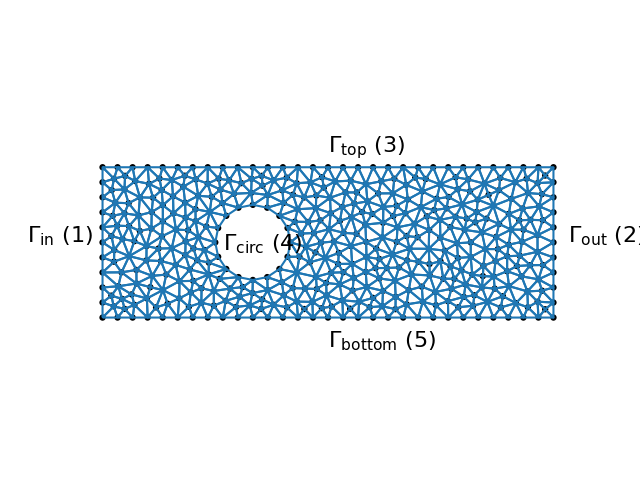

In [4]:
# NBVAL_IGNORE_OUTPUT
axes = plot(mesh);
axes.axis("off")
axes.annotate("$\Gamma_\mathrm{in}$ (1)", xy=(-5, 5), annotation_clip=False, fontsize=16)
axes.annotate("$\Gamma_\mathrm{out}$ (2)", xy=(31, 5), annotation_clip=False, fontsize=16)
axes.annotate("$\Gamma_\mathrm{top}$ (3)", xy=(15, 11), annotation_clip=False, fontsize=16)
axes.annotate("$\Gamma_\mathrm{bottom}$ (5)", xy=(15, -2), annotation_clip=False, fontsize=16)
axes.annotate("$\Gamma_\mathrm{circ}$ (4)", xy=(8, 4.5), annotation_clip=False, fontsize=16);

## The forward problem

The forward problem should be familiar by now, we create a mixed function space for $u$ and $p$ and set up trial and test functions.  We specify a parabolic velocity at the inflow, and no-slip (zero velocity) conditions on the side walls.  The zero-pressure outflow condition is enforced weakly.

Our variational formulation for Stokes reads as follows.  Find $(u, p) \in V\times Q$ such that:

$$
\begin{align}
\int_\Omega \nu \nabla u : \nabla v\,\text{d}x
- \int_\Omega p \nabla \cdot v\,\text{d}x 
- \int_{\Gamma_{\text{circ}}} \nu (\nabla u \cdot n) \cdot v\,\text{d}s  &= 0 \quad \forall v \in V\\
- \int_\Omega q \nabla \cdot u\,\text{d}x &= 0 \quad \forall q \in Q.\\
u &= 0 \quad \text{on $\Gamma_{\text{top}} \cup \Gamma_{\text{bottom}}$}\\
u &= [\frac{y(10 - y)}{25}, 0]^T \quad \text{on $\Gamma_{\text{in}}$}\\
u &= g \quad \text{on $\Gamma_{\text{circ}}$}\\
\frac{\text{d}p}{\text{d}n} &= 0 \quad \text{on $\Gamma_{\text{out}}$}
\end{align}
$$

In [5]:
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
W = V*Q

v, q = TestFunctions(W)
u, p = TrialFunctions(W)

nu = Constant(1)     # Viscosity coefficient

x, y = SpatialCoordinate(mesh)
u_inflow = as_vector([y*(10-y)/25.0, 0])

noslip = DirichletBC(W.sub(0), (0, 0), (3, 5))
inflow = DirichletBC(W.sub(0), interpolate(u_inflow, V), 1)
static_bcs = [inflow, noslip]

The boundary value, $g$, on the circle will be our control variable.  To do this, we define a `Function` which will hold the boundary values, we then build a `DirichletBC` object as normal.

In [6]:
g = Function(V, name="Control")
controlled_bcs = [DirichletBC(W.sub(0), g, 4)]
bcs = static_bcs + controlled_bcs

Now we define the bilinear and linear forms.

In [7]:
a = nu*inner(grad(u), grad(v))*dx - inner(p, div(v))*dx - inner(q, div(u))*dx
L = Constant(0)*q*dx

Now let's solve the forward problem so that `firedrake-adjoint` annotates it.  We'll also take a look at the solution.

In [8]:
w = Function(W)
solve(a == L, w, bcs=bcs, solver_parameters={"pc_type": "lu", "mat_type": "aij",
                                             "pc_factor_shift_type": "inblocks"})

<IPython.core.display.Javascript object>


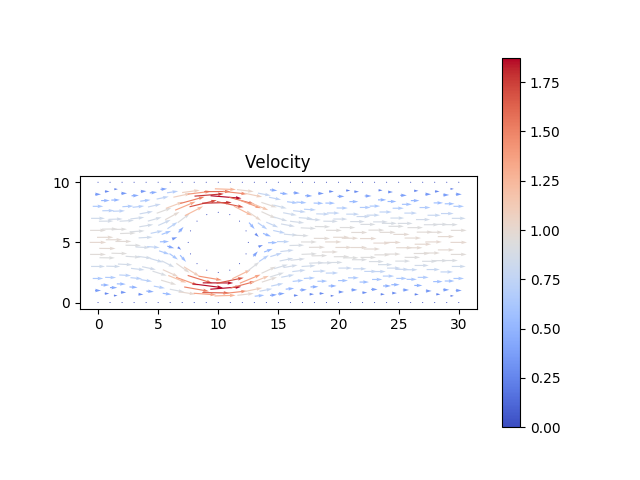

<IPython.core.display.Javascript object>


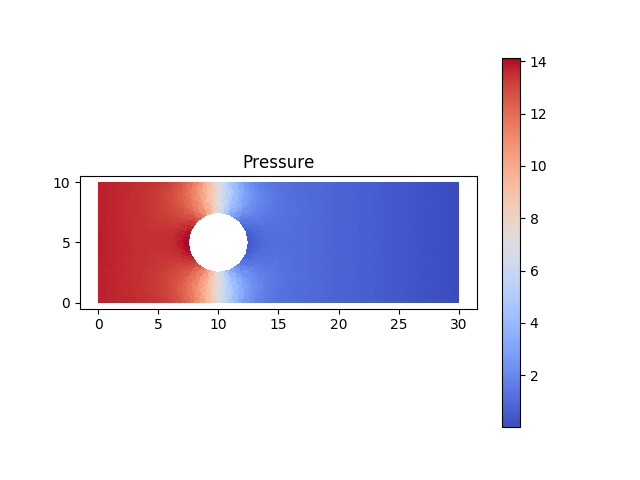

In [9]:
# NBVAL_IGNORE_OUTPUT
u_init, p_init = w.split()
axes = plot(u_init);
axes.set_aspect("equal")
axes.set_title("Velocity")
axes = plot(p_init)
axes.set_aspect("equal")
axes.set_title("Pressure");

## The optimisation problem

Now we come to the optimisation problem.  We first define the functional we wish to minimise, this is done by assembling a form that produces a number.  Then we specify a control variable, and produce a "reduced" functional (the evaluation of the functional at a given control value).  We then minimise the functional, producing an optimised control value.  See [the dolfin-adjoint documentation](http://www.dolfin-adjoint.org/en/latest/documentation/) for more details on reduced functionals.

In [10]:
u, p = split(w)
alpha = Constant(10)

J = assemble(1./2*inner(grad(u), grad(u))*dx + alpha/2*inner(g, g)*ds(4))
m = Control(g)
Jhat = ReducedFunctional(J, m)

In [11]:
g_opt = minimize(Jhat)

Now let's take a look at the optimised control.  The initial boundary condition on the circle was no slip.  We see now that the optimised boundary condition has a significant outflow in the hole.

<IPython.core.display.Javascript object>


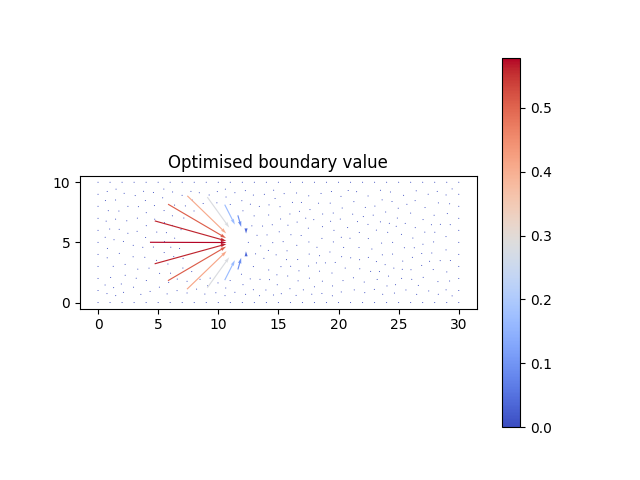

In [12]:
# NBVAL_IGNORE_OUTPUT
axes = plot(g_opt, scale=3)
axes.set_aspect("equal")
axes.set_title("Optimised boundary value");

Let's compare the difference in the initial and final values of the functional.  This is done by calling the `ReducedFunctional` object with the control at the requested value.

In [13]:
print("Jhat(g) = %.8g\nJhat(g_opt) = %.8g" % (Jhat(g), Jhat(g_opt)))

Jhat(g) = 46.078212
Jhat(g_opt) = 19.896719


To see the optimised flow field, we solve the same problem again, only with the new (optimised) value for the boundary data on $\Gamma_\text{circ}$.  This time we're not interested in annotating the solve, so we tell `firedrake-adjoint` to ignore it by passing `annotate=False`.

In [14]:
g.assign(g_opt)
w_opt = Function(W)
solve(a == L, w_opt, bcs=bcs, solver_parameters={"pc_type": "lu", "mat_type": "aij",
                                                 "pc_factor_shift_type": "inblocks"},
      annotate=False)

<IPython.core.display.Javascript object>


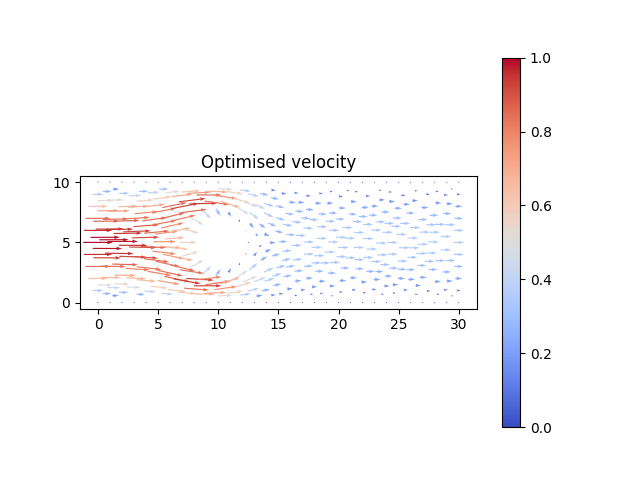

<IPython.core.display.Javascript object>


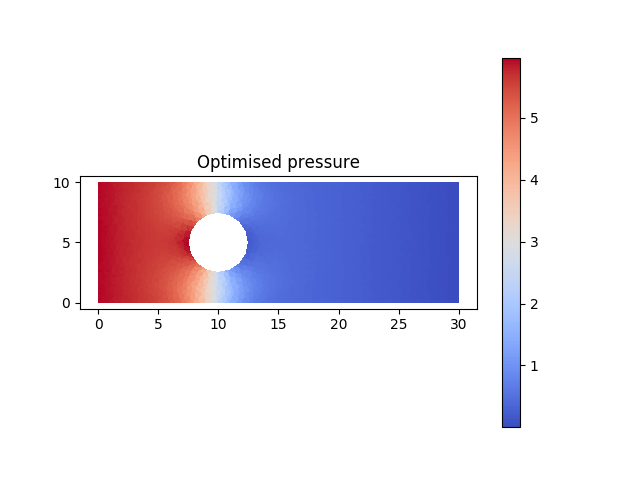

In [15]:
# NBVAL_IGNORE_OUTPUT
u_opt, p_opt = w_opt.split()
axes = plot(u_opt)
axes.set_aspect("equal")
axes.set_title("Optimised velocity");
axes = plot(p_opt)
axes.set_aspect("equal")
axes.set_title("Optimised pressure");

Now that we are done optimising this problem, and so that the recorded annotations do not leak into the exercise, we tell `firedrake-adjoint` to *forget* all of the entries on its tape.

In [16]:
tape = get_working_tape()
tape.clear_tape()

# Exercise

Modify the problem so that the boundary conditions are as follows:

$$
\begin{split}
u &= (1, 0) \quad &\text{on $\Gamma_\text{top}$}\\
u &= (0, 0) \quad&\text{on $\Gamma_\text{in}$}\\
u &= g \quad&\text{on $\Gamma_\text{out} \cup \Gamma_\text{bottom}$}\\
p &= 0 \quad&\text{on $\Gamma_\text{circ}$}
\end{split}
$$

and again optimise for $g$ in the same manner.

The change in the velocity and pressure fields will be less obvious than in the previous example, to verify that there is a difference try plotting the difference between the initial field for $u$ and the optimised field for $u$.

- Hint 1: you will have to redefine the list of boundary conditions.
- Hint 2: to compute the pointwise difference between two fields in the same function space, write: `assemble(field_a - field_b)`.